# <a id='toc1_'></a>[TWO MOONS DATASET EXPERIMENTS](#toc0_)

The purpose of this notebook will be to analyze the behavior of the networks on a toy task, namely: the two moons dataset. This dataset is a simple binary classification task, where the goal is to separate two half-moon shaped clusters. The dataset is generated using the `make_moons` function from `sklearn.datasets`.

We want to see if the network manages to have uncertainty in the regions where the two moons are close to each other, and if it is able to correctly classify the points in the two moons.

This experiment will be conducted on both Deep Neural Networks (DNNs) and Binary Neural Networks (BiNNs).

**Table of contents**<a id='toc0_'></a>    
- [TWO MOONS DATASET EXPERIMENTS](#toc1_)    
  - [Imports](#toc1_1_)    
  - [Train / test split](#toc1_2_)    
  - [Global variables](#toc1_3_)    
  - [Deep Neural Network](#toc1_4_)    
    - [Configuration and training of the network](#toc1_4_1_)    
    - [Exploiting the results](#toc1_4_2_)    
  - [Binary Neural Networks](#toc1_5_)    
    - [Configuration and training of the network](#toc1_5_1_)    
    - [Exploiting the results](#toc1_5_2_)    
    - [Straight Through Estimator with tanh](#toc1_5_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)
Importing libraries and setting the global variables

In [63]:

from utils import *
from dataloader import *
import models
import torch
import trainer
from optimizer import *
from sklearn.datasets import make_moons
import palettable
from torch.utils.data import DataLoader, TensorDataset
from models.layers.activation import Sign

SEED = 0  # Random seed
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### SEED ###
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.set_default_device(DEVICE)
np.random.seed(SEED)
torch.manual_seed(SEED)
    

## <a id='toc1_2_'></a>[Train / test split](#toc0_)

We split the dataset into a train and test set. The test set will be used to evaluate the performance of the network, while the train set will be used to train the network. We separate the data into:
- `x_train`: the input data for the training set with 1024 points
- `y_train`: the labels for the training set with 1024 points
- `x_test`: the input data for the test set with 256 points
- `y_test`: the labels for the test set with 256 points

In [64]:
tr_size = 250
te_size = 50

### CREATE TWO MOONS DATASET ###
X, y = make_moons(n_samples=tr_size+te_size, noise=0.1, random_state=SEED)

# normalize dataset
X = (X - X.mean(axis=0)) / X.std(axis=0)

X_train = X[:tr_size]
y_train = y[:tr_size]
X_test = X[tr_size:]
y_test = y[tr_size:]

INPUT_SIZE = X_train.shape[1]

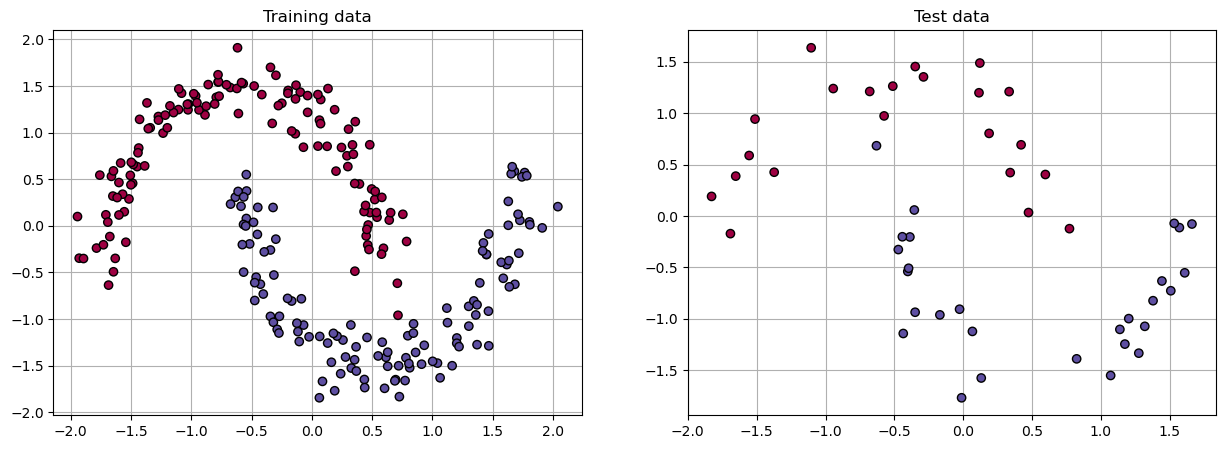

In [65]:
### PLOT X, y ###
# subplot for training data and test data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].grid(True)
ax[1].grid(True)
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)
ax[0].set_title("Training data")
ax[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)
ax[1].set_title("Test data")
plt.show()

## <a id='toc1_3_'></a>[Global variables](#toc0_)

In [66]:

# Global parameters
SOFTMAX = False

LAYER_SIZE = [32, 32]
EPOCHS = 3000
BATCH_SIZE = tr_size
LEARNING_RATE = 0.05

if not SOFTMAX:
    SAVE_FOLDER = "saved-two-moons-2"
    OUT = 1
    OUTPUT_FUNCTION = "sigmoid"
    CRITERION = torch.functional.F.binary_cross_entropy
else:
    SAVE_FOLDER = "saved-two-moons-softmax-2"
    OUT = 2
    OUTPUT_FUNCTION = "log_softmax"
    CRITERION = torch.functional.F.nll_loss

## <a id='toc1_4_'></a>[Deep Neural Network](#toc0_)

### <a id='toc1_4_1_'></a>[Configuration and training of the network](#toc0_)

We configure the network by setting the parameters within a dictionary.

In [89]:

### NETWORK CONFIGURATION ###
network_data = {
    "nn_type": models.BiNN,
    "nn_parameters": {
        "layers": [INPUT_SIZE] + LAYER_SIZE + [OUT],
        "device": DEVICE,
        "dropout": False, # Dropout layers
        "batchnorm": True, # Batch normalization layers
        "bnmomentum": 0,
        "bneps": 0,
        "bias": False,
        "affine": False,
        "latent_weights": False, # Latent weights for BNN
        "activation_function": torch.functional.F.relu, # Activation function for hidden layers
        "output_function": OUTPUT_FUNCTION, # Activation function for output layer (as loss function is BCE_with_logits, no activation function is needed)
        "lambda_init": 0,
    },
    "training_parameters": {
        'n_epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        "test_mcmc_samples": 1,
    },
    "criterion": CRITERION,
    "optimizer": BinaryHomosynapticUncertaintyTest,
    "optimizer_parameters": {
        "lr": LEARNING_RATE*4,
        "num_mcmc_samples": 10,
        "update":2,
        "gamma":0,
        "scale":0,
    },
}

train_tensor = GPUTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long(), device=DEVICE)
test_tensor = GPUTensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long(), device=DEVICE)

if "binary_cross_entropy" in network_data["criterion"].__name__:
    train_tensor.targets = train_tensor.targets.float().unsqueeze(1)
    test_tensor.targets = test_tensor.targets.float().unsqueeze(1)

train_loader = GPUDataLoader(train_tensor, batch_size=network_data["training_parameters"]["batch_size"], shuffle=True)
test_loader = GPUDataLoader(test_tensor, batch_size=te_size, shuffle=False)

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### ACCURACY INITIALIZATION ###
accuracies = []
batch_size = network_data['training_parameters']['batch_size']

### NETWORK INITIALIZATION ###
model = network_data['nn_type'](**network_data['nn_parameters'])

### INSTANTIATE THE TRAINER ###
network = trainer.BayesTrainer(batch_size=batch_size,
                                model=model, **network_data, device=DEVICE)
### TRAINING ###
network.fit(
    train_loader, 
    **network_data['training_parameters'], 
    test_loader=[test_loader, train_loader],
    name_loader=["Test accuracy", "Train accuracy"]
)

Epoch 5/3000:   0%|          | 0/3000 [00:00<?, ?it/s, loss=0.56] 

Epoch 14/3000:   0%|          | 7/3000 [00:00<00:49, 60.75it/s, loss=0.45] 

Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 34.80%
Testing accuracy: 
	Test accuracy: 62.00%
	Train accuracy: 64.00%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 70.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 42.00%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 80.40%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 83.60%
Testing accuracy: 
	Test accuracy: 78.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 76.80%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%


Epoch 28/3000:   1%|          | 23/3000 [00:00<00:42, 69.46it/s, loss=0.424]

	Train accuracy: 63.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 52.40%
Testing accuracy: 
	Test accuracy: 68.00%
	Train accuracy: 48.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 75.60%
Testing accuracy: 
	Test accuracy: 72.00%
	Train accuracy: 71.20%
Testing accuracy: 
	Test accuracy: 74.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 66.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 74.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 76.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 81.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 87.20%


Epoch 42/3000:   1%|▏         | 39/3000 [00:00<00:39, 74.20it/s, loss=0.413]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 81.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 78.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 82.40%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 87.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 88.80%


Epoch 57/3000:   2%|▏         | 55/3000 [00:00<00:42, 68.62it/s, loss=0.398]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 85.60%


Epoch 73/3000:   2%|▏         | 71/3000 [00:01<00:39, 73.45it/s, loss=0.402]

Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 80.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 94.40%
Testing a

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 79.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%


Epoch 105/3000:   3%|▎         | 104/3000 [00:01<00:37, 77.23it/s, loss=0.394]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 80.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing a

Epoch 119/3000:   4%|▎         | 112/3000 [00:01<00:37, 77.12it/s, loss=0.4]  

	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%


Epoch 134/3000:   4%|▍         | 128/3000 [00:01<00:37, 76.13it/s, loss=0.379]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%


Epoch 151/3000:   5%|▍         | 145/3000 [00:02<00:37, 75.65it/s, loss=0.38] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing a

Epoch 167/3000:   5%|▌         | 162/3000 [00:02<00:36, 77.74it/s, loss=0.392]

	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train acc

Epoch 182/3000:   6%|▌         | 178/3000 [00:02<00:36, 77.06it/s, loss=0.37] 

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing ac

Epoch 196/3000:   6%|▋         | 194/3000 [00:02<00:38, 73.28it/s, loss=0.368]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%


Epoch 211/3000:   7%|▋         | 210/3000 [00:02<00:38, 72.59it/s, loss=0.378]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 70.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%


Epoch 227/3000:   7%|▋         | 218/3000 [00:03<00:39, 70.88it/s, loss=0.366]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 242/3000:   8%|▊         | 235/3000 [00:03<00:37, 73.55it/s, loss=0.367]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 69.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing a

Epoch 255/3000:   8%|▊         | 251/3000 [00:03<00:40, 67.87it/s, loss=0.366]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 272/3000:   9%|▉         | 268/3000 [00:03<00:36, 74.83it/s, loss=0.372]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing a

Epoch 287/3000:   9%|▉         | 284/3000 [00:03<00:37, 72.77it/s, loss=0.367]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%


Epoch 302/3000:  10%|█         | 300/3000 [00:04<00:37, 72.01it/s, loss=0.373]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 76.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%


Epoch 319/3000:  11%|█         | 317/3000 [00:04<00:35, 75.98it/s, loss=0.374]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing a

Epoch 335/3000:  11%|█         | 335/3000 [00:04<00:33, 79.15it/s, loss=0.373]

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 350/3000:  11%|█▏        | 343/3000 [00:04<00:33, 78.59it/s, loss=0.366]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%


Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing a

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 


Epoch 396/3000:  13%|█▎        | 392/3000 [00:05<00:34, 74.65it/s, loss=0.366]

	Test accuracy: 92.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accu

Epoch 413/3000:  14%|█▎        | 410/3000 [00:05<00:32, 78.89it/s, loss=0.36] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing ac

Epoch 430/3000:  14%|█▍        | 428/3000 [00:05<00:32, 80.09it/s, loss=0.359]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 447/3000:  15%|█▍        | 446/3000 [00:05<00:31, 80.32it/s, loss=0.373]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 97.20%
Testing a

Epoch 463/3000:  15%|█▌        | 455/3000 [00:06<00:32, 78.82it/s, loss=0.368]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Epoch 479/3000:  16%|█▌        | 473/3000 [00:06<00:31, 80.20it/s, loss=0.364]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing 

Epoch 496/3000:  16%|█▋        | 491/3000 [00:06<00:30, 81.12it/s, loss=0.357]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testin

Epoch 511/3000:  17%|█▋        | 508/3000 [00:06<00:33, 75.42it/s, loss=0.357]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.20%


Epoch 528/3000:  18%|█▊        | 526/3000 [00:06<00:31, 78.84it/s, loss=0.358]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing a

Epoch 545/3000:  18%|█▊        | 544/3000 [00:07<00:30, 80.54it/s, loss=0.352]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing a

Epoch 562/3000:  19%|█▊        | 562/3000 [00:07<00:30, 80.92it/s, loss=0.365]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing ac

Epoch 595/3000:  20%|█▉        | 589/3000 [00:07<00:29, 81.54it/s, loss=0.357]

	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test acc

Epoch 612/3000:  20%|██        | 607/3000 [00:08<00:29, 81.71it/s, loss=0.366]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing a

Epoch 629/3000:  21%|██        | 625/3000 [00:08<00:28, 81.92it/s, loss=0.366]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing a

Epoch 645/3000:  21%|██▏       | 643/3000 [00:08<00:29, 80.34it/s, loss=0.352]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing a

Epoch 662/3000:  22%|██▏       | 661/3000 [00:08<00:28, 81.75it/s, loss=0.372]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 679/3000:  23%|██▎       | 679/3000 [00:08<00:28, 82.54it/s, loss=0.355]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 696/3000:  23%|██▎       | 688/3000 [00:09<00:28, 82.41it/s, loss=0.359]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Epoch 712/3000:  24%|██▎       | 706/3000 [00:09<00:28, 79.60it/s, loss=0.355]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%


Epoch 727/3000:  24%|██▍       | 723/3000 [00:09<00:28, 78.82it/s, loss=0.365]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing ac

Epoch 744/3000:  25%|██▍       | 741/3000 [00:09<00:27, 80.80it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing ac

Epoch 761/3000:  25%|██▌       | 759/3000 [00:09<00:27, 81.36it/s, loss=0.368]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing a

Epoch 773/3000:  26%|██▌       | 768/3000 [00:10<00:28, 79.41it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%


Epoch 788/3000:  26%|██▌       | 784/3000 [00:10<00:32, 67.81it/s, loss=0.36] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 803/3000:  27%|██▋       | 800/3000 [00:10<00:30, 71.20it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing ac

Epoch 818/3000:  27%|██▋       | 817/3000 [00:10<00:29, 74.55it/s, loss=0.353]

	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test acc

Epoch 832/3000:  28%|██▊       | 825/3000 [00:10<00:29, 72.84it/s, loss=0.358]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%


Epoch 847/3000:  28%|██▊       | 841/3000 [00:11<00:31, 69.60it/s, loss=0.357]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%


Epoch 863/3000:  29%|██▊       | 857/3000 [00:11<00:29, 72.88it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing 

Epoch 878/3000:  29%|██▉       | 873/3000 [00:11<00:29, 72.28it/s, loss=0.363]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%


Epoch 894/3000:  30%|██▉       | 890/3000 [00:11<00:28, 75.31it/s, loss=0.354]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing 

Epoch 910/3000:  30%|███       | 908/3000 [00:11<00:26, 78.53it/s, loss=0.355]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing 

Epoch 927/3000:  31%|███       | 926/3000 [00:12<00:25, 80.97it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Epoch 944/3000:  31%|███▏      | 944/3000 [00:12<00:25, 81.61it/s, loss=0.357]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.00%
Testing a

Epoch 958/3000:  32%|███▏      | 953/3000 [00:12<00:27, 73.88it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 975/3000:  32%|███▏      | 970/3000 [00:12<00:26, 76.53it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing ac

Epoch 989/3000:  33%|███▎      | 987/3000 [00:12<00:26, 76.52it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 88.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%


Epoch 1006/3000:  33%|███▎      | 1004/3000 [00:13<00:25, 77.95it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing a

Epoch 1022/3000:  34%|███▍      | 1021/3000 [00:13<00:25, 78.05it/s, loss=0.354]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing a

Epoch 1039/3000:  35%|███▍      | 1038/3000 [00:13<00:24, 79.57it/s, loss=0.357]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.80%
Testing a

Epoch 1054/3000:  35%|███▌      | 1054/3000 [00:13<00:25, 75.84it/s, loss=0.357]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%


Epoch 1071/3000:  35%|███▌      | 1062/3000 [00:13<00:25, 76.15it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing a

Epoch 1083/3000:  36%|███▌      | 1079/3000 [00:14<00:24, 77.11it/s, loss=0.359]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%


Epoch 1099/3000:  36%|███▋      | 1095/3000 [00:14<00:26, 71.36it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing ac

Epoch 1116/3000:  37%|███▋      | 1113/3000 [00:14<00:24, 77.04it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing a

Epoch 1132/3000:  38%|███▊      | 1130/3000 [00:14<00:24, 77.81it/s, loss=0.357]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing 

Epoch 1149/3000:  38%|███▊      | 1147/3000 [00:15<00:23, 78.57it/s, loss=0.354]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing a

Epoch 1165/3000:  39%|███▉      | 1165/3000 [00:15<00:23, 79.68it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing 

Epoch 1182/3000:  39%|███▉      | 1174/3000 [00:15<00:22, 79.84it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 1196/3000:  40%|███▉      | 1192/3000 [00:15<00:22, 78.92it/s, loss=0.35] 

	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%


Epoch 1212/3000:  40%|████      | 1208/3000 [00:15<00:23, 75.15it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%


Epoch 1228/3000:  41%|████      | 1226/3000 [00:16<00:22, 79.27it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.80%
Testing ac

Epoch 1245/3000:  41%|████▏     | 1244/3000 [00:16<00:22, 79.70it/s, loss=0.357]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing 

Epoch 1261/3000:  42%|████▏     | 1253/3000 [00:16<00:21, 80.26it/s, loss=0.354]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing a

Epoch 1278/3000:  42%|████▏     | 1271/3000 [00:16<00:21, 81.33it/s, loss=0.356]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing a

Epoch 1295/3000:  43%|████▎     | 1289/3000 [00:16<00:20, 81.91it/s, loss=0.355]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing a

Epoch 1311/3000:  44%|████▎     | 1307/3000 [00:17<00:20, 81.33it/s, loss=0.352]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Epoch 1327/3000:  44%|████▍     | 1325/3000 [00:17<00:21, 79.47it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing ac

Epoch 1342/3000:  45%|████▍     | 1341/3000 [00:17<00:22, 75.24it/s, loss=0.368]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%


Epoch 1359/3000:  45%|████▌     | 1359/3000 [00:17<00:20, 78.65it/s, loss=0.352]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 1375/3000:  46%|████▌     | 1375/3000 [00:17<00:20, 78.41it/s, loss=0.352]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 1392/3000:  46%|████▌     | 1384/3000 [00:18<00:20, 79.69it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing 

Epoch 1408/3000:  47%|████▋     | 1402/3000 [00:18<00:20, 78.81it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing ac

Epoch 1425/3000:  47%|████▋     | 1419/3000 [00:18<00:19, 79.96it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing ac

Epoch 1442/3000:  48%|████▊     | 1437/3000 [00:18<00:19, 81.24it/s, loss=0.36] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing ac

Epoch 1457/3000:  48%|████▊     | 1455/3000 [00:18<00:19, 81.29it/s, loss=0.356]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%


Epoch 1474/3000:  49%|████▉     | 1473/3000 [00:19<00:19, 79.53it/s, loss=0.356]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing a

Epoch 1490/3000:  50%|████▉     | 1489/3000 [00:19<00:19, 77.51it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 1505/3000:  50%|████▉     | 1498/3000 [00:19<00:19, 78.96it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accu

Epoch 1555/3000:  52%|█████▏    | 1549/3000 [00:20<00:17, 81.10it/s, loss=0.353]

	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 86.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train acc

Epoch 1571/3000:  52%|█████▏    | 1567/3000 [00:20<00:17, 81.50it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing ac

Epoch 1585/3000:  53%|█████▎    | 1585/3000 [00:20<00:19, 74.35it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%


Epoch 1601/3000:  53%|█████▎    | 1601/3000 [00:20<00:18, 75.42it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing ac

Epoch 1618/3000:  54%|█████▎    | 1610/3000 [00:20<00:18, 77.14it/s, loss=0.349]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing ac

Epoch 1635/3000:  54%|█████▍    | 1627/3000 [00:21<00:17, 78.37it/s, loss=0.349]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing a

Epoch 1652/3000:  55%|█████▍    | 1645/3000 [00:21<00:17, 79.70it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing ac

Epoch 1667/3000:  55%|█████▌    | 1663/3000 [00:21<00:16, 79.06it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing a

Epoch 1684/3000:  56%|█████▌    | 1681/3000 [00:21<00:16, 81.06it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 1701/3000:  57%|█████▋    | 1699/3000 [00:21<00:15, 81.91it/s, loss=0.352]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing ac

Epoch 1715/3000:  57%|█████▋    | 1708/3000 [00:22<00:16, 79.19it/s, loss=0.347]

Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 1732/3000:  57%|█████▊    | 1725/3000 [00:22<00:16, 76.24it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing a

Epoch 1749/3000:  58%|█████▊    | 1743/3000 [00:22<00:15, 79.26it/s, loss=0.355]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 1765/3000:  59%|█████▊    | 1759/3000 [00:22<00:15, 78.71it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 1781/3000:  59%|█████▉    | 1777/3000 [00:23<00:15, 80.08it/s, loss=0.351]

	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train acc

Epoch 1797/3000:  60%|█████▉    | 1794/3000 [00:23<00:15, 77.49it/s, loss=0.349]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing a

Epoch 1815/3000:  60%|██████    | 1812/3000 [00:23<00:14, 80.99it/s, loss=0.359]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Epoch 1831/3000:  61%|██████    | 1830/3000 [00:23<00:14, 80.99it/s, loss=0.354]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing ac

Epoch 1847/3000:  62%|██████▏   | 1847/3000 [00:23<00:14, 79.33it/s, loss=0.349]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 1862/3000:  62%|██████▏   | 1855/3000 [00:24<00:14, 79.05it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%


Epoch 1878/3000:  62%|██████▏   | 1871/3000 [00:24<00:15, 73.82it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.00%


Epoch 1894/3000:  63%|██████▎   | 1889/3000 [00:24<00:14, 78.77it/s, loss=0.357]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 1910/3000:  64%|██████▎   | 1906/3000 [00:24<00:13, 78.71it/s, loss=0.352]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing ac

Epoch 1927/3000:  64%|██████▍   | 1923/3000 [00:24<00:13, 79.59it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing a

Epoch 1944/3000:  65%|██████▍   | 1941/3000 [00:25<00:13, 80.45it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing a

Epoch 1975/3000:  66%|██████▌   | 1968/3000 [00:25<00:12, 79.74it/s, loss=0.346]

	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 1992/3000:  66%|██████▌   | 1984/3000 [00:25<00:13, 76.59it/s, loss=0.344]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Epoch 2008/3000:  67%|██████▋   | 2002/3000 [00:25<00:12, 78.96it/s, loss=0.348]

	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accu

Epoch 2022/3000:  67%|██████▋   | 2018/3000 [00:26<00:12, 76.72it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2038/3000:  68%|██████▊   | 2035/3000 [00:26<00:12, 77.85it/s, loss=0.347]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing ac

Epoch 2054/3000:  68%|██████▊   | 2052/3000 [00:26<00:12, 77.19it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 2071/3000:  69%|██████▉   | 2070/3000 [00:26<00:11, 80.50it/s, loss=0.352]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing ac

Epoch 2103/3000:  70%|██████▉   | 2097/3000 [00:27<00:11, 78.22it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing ac

Epoch 2119/3000:  70%|███████   | 2114/3000 [00:27<00:11, 78.16it/s, loss=0.356]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing ac

Epoch 2136/3000:  71%|███████   | 2131/3000 [00:27<00:10, 79.42it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing a

Epoch 2152/3000:  72%|███████▏  | 2148/3000 [00:27<00:10, 79.52it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing a

Epoch 2169/3000:  72%|███████▏  | 2166/3000 [00:27<00:10, 80.91it/s, loss=0.357]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing ac

Epoch 2186/3000:  73%|███████▎  | 2184/3000 [00:28<00:10, 80.82it/s, loss=0.355]

Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 2202/3000:  73%|███████▎  | 2202/3000 [00:28<00:09, 81.45it/s, loss=0.352]

	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accu

Epoch 2218/3000:  74%|███████▎  | 2211/3000 [00:28<00:10, 77.98it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing ac

Epoch 2234/3000:  74%|███████▍  | 2228/3000 [00:28<00:09, 77.77it/s, loss=0.352]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing ac

Epoch 2251/3000:  75%|███████▍  | 2246/3000 [00:28<00:09, 80.19it/s, loss=0.349]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing ac

Epoch 2268/3000:  75%|███████▌  | 2264/3000 [00:29<00:09, 80.85it/s, loss=0.346]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 2283/3000:  76%|███████▌  | 2282/3000 [00:29<00:09, 79.62it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing a

Epoch 2300/3000:  77%|███████▋  | 2300/3000 [00:29<00:08, 81.16it/s, loss=0.342]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 2317/3000:  77%|███████▋  | 2309/3000 [00:29<00:08, 81.47it/s, loss=0.346]

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Epoch 2332/3000:  78%|███████▊  | 2327/3000 [00:29<00:08, 77.11it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%


Epoch 2349/3000:  78%|███████▊  | 2345/3000 [00:30<00:08, 79.58it/s, loss=0.349]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 2366/3000:  79%|███████▊  | 2362/3000 [00:30<00:07, 79.98it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing ac

Epoch 2381/3000:  79%|███████▉  | 2380/3000 [00:30<00:07, 78.01it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2397/3000:  80%|███████▉  | 2396/3000 [00:30<00:07, 77.51it/s, loss=0.344]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 82.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing ac

Epoch 2412/3000:  80%|████████  | 2412/3000 [00:31<00:07, 75.24it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%


Epoch 2424/3000:  81%|████████  | 2420/3000 [00:31<00:07, 73.67it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 92.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2437/3000:  81%|████████  | 2435/3000 [00:31<00:08, 65.41it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%


Epoch 2449/3000:  82%|████████▏ | 2449/3000 [00:31<00:09, 61.22it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2465/3000:  82%|████████▏ | 2458/3000 [00:31<00:08, 67.06it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Epoch 2480/3000:  82%|████████▏ | 2473/3000 [00:32<00:07, 67.27it/s, loss=0.349]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%


Epoch 2493/3000:  83%|████████▎ | 2488/3000 [00:32<00:07, 67.76it/s, loss=0.346]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2507/3000:  83%|████████▎ | 2504/3000 [00:32<00:07, 68.63it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%


Epoch 2521/3000:  84%|████████▍ | 2518/3000 [00:32<00:07, 68.37it/s, loss=0.351]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%


Epoch 2536/3000:  84%|████████▍ | 2533/3000 [00:32<00:06, 68.22it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%


Epoch 2550/3000:  85%|████████▍ | 2549/3000 [00:33<00:06, 70.56it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2563/3000:  85%|████████▌ | 2557/3000 [00:33<00:06, 70.97it/s, loss=0.349]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%


Epoch 2577/3000:  86%|████████▌ | 2572/3000 [00:33<00:06, 64.24it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 


Epoch 2592/3000:  86%|████████▋ | 2588/3000 [00:33<00:05, 70.04it/s, loss=0.35] 

	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accu

Epoch 2607/3000:  87%|████████▋ | 2604/3000 [00:33<00:05, 71.15it/s, loss=0.358]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 98.40%


Epoch 2622/3000:  87%|████████▋ | 2620/3000 [00:34<00:05, 72.58it/s, loss=0.352]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 90.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%


Epoch 2636/3000:  88%|████████▊ | 2636/3000 [00:34<00:05, 69.69it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2650/3000:  88%|████████▊ | 2644/3000 [00:34<00:05, 68.38it/s, loss=0.347]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%


Epoch 2665/3000:  89%|████████▊ | 2659/3000 [00:34<00:04, 70.33it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%


Epoch 2681/3000:  89%|████████▉ | 2675/3000 [00:34<00:04, 72.29it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 2710/3000:  90%|█████████ | 2707/3000 [00:35<00:04, 71.11it/s, loss=0.344]

	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2726/3000:  91%|█████████ | 2723/3000 [00:35<00:03, 73.90it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing ac

Epoch 2741/3000:  91%|█████████▏| 2739/3000 [00:35<00:03, 73.59it/s, loss=0.347]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2756/3000:  92%|█████████▏| 2756/3000 [00:35<00:03, 74.03it/s, loss=0.346]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2770/3000:  92%|█████████▏| 2764/3000 [00:36<00:03, 70.94it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2784/3000:  93%|█████████▎| 2780/3000 [00:36<00:03, 69.15it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


Epoch 2798/3000:  93%|█████████▎| 2796/3000 [00:36<00:02, 69.12it/s, loss=0.348]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%


Epoch 2815/3000:  94%|█████████▍| 2813/3000 [00:36<00:02, 74.07it/s, loss=0.363]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing ac

Epoch 2830/3000:  94%|█████████▍| 2829/3000 [00:37<00:02, 72.95it/s, loss=0.35] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%


Epoch 2846/3000:  95%|█████████▍| 2846/3000 [00:37<00:02, 76.71it/s, loss=0.349]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 91.60%
Testing a

Epoch 2862/3000:  95%|█████████▌| 2854/3000 [00:37<00:01, 77.03it/s, loss=0.346]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 96.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%


Epoch 2878/3000:  96%|█████████▌| 2871/3000 [00:37<00:01, 77.79it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 2893/3000:  96%|█████████▌| 2887/3000 [00:37<00:01, 72.79it/s, loss=0.353]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.20%


Epoch 2910/3000:  97%|█████████▋| 2903/3000 [00:38<00:01, 75.66it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing ac

Epoch 2926/3000:  97%|█████████▋| 2921/3000 [00:38<00:01, 78.20it/s, loss=0.347]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing a

Epoch 2943/3000:  98%|█████████▊| 2937/3000 [00:38<00:00, 76.58it/s, loss=0.341]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 100.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing a

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing ac

Epoch 2975/3000:  99%|█████████▉| 2971/3000 [00:38<00:00, 79.35it/s, loss=0.366]

	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 95.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accu

Epoch 2992/3000: 100%|█████████▉| 2989/3000 [00:39<00:00, 80.71it/s, loss=0.359]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 93.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing ac

Epoch 3000/3000: 100%|██████████| 3000/3000 [00:39<00:00, 76.52it/s, loss=0.345]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 96.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%


### <a id='toc1_4_2_'></a>[Exploiting the results](#toc0_)

In [90]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors

    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap

    cmap = LinearSegmentedColormap.from_list(name=name,
                                             colors=[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap
custom_map = custom_div_cmap(
    11, mincol='#86C29C', midcol='0.9', maxcol='#F5D752')

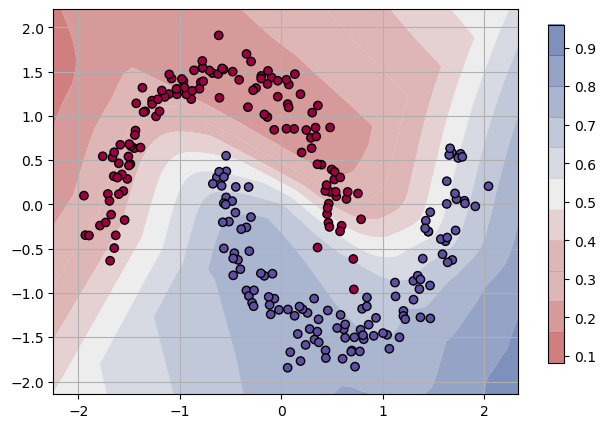

In [91]:
### CREATE A MESHGRID ###
# Create a meshgrid for the whole dataset such that we can plot the predictions for each point
h = .01  # step size in the mesh
buffer = 0.3 # buffer for the axes
x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer # min and max of the first feature
y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer # min and max of the second feature
xx,yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.from_numpy((grid - X.mean(axis=0)) / X.std(axis=0)).float().to(DEVICE)
# mincol in red hexa code, axcol in blue hexa code
custom_map = custom_div_cmap(
    11, mincol='#B22222', midcol='0.9', maxcol='#4863A0')

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### PREDICT ###
N_TEST_SAMPLES = 100
clevels = 9
Z = network.predict(grid, N_TEST_SAMPLES) 
Z = torch.stack(Z, dim=0)
Z = Z.mean(dim=0)
# Depending on the loss function, we need to apply an activation function to the output
if "binary_cross_entropy" in network_data["criterion"].__name__:
    Z = Z.cpu().reshape(xx.shape)
else:
    Z = torch.exp(Z)
    Z = torch.max(Z, dim=1)[0].reshape(xx.shape).cpu()

### PLOT ###
# Plot the predictions with the uncertainty
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.grid(True)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)

# Plot the uncertainty with contourf based on the value of Z
c = ax.contourf(xx, yy, Z, alpha=0.7, levels=clevels, antialiased=True, cmap=custom_map, zorder=1)

# Add a colorbar
colorbar = fig.colorbar(c, ax=ax, ticks=np.arange(0, 1.1, 1 / (clevels+1)))
# force the leftbar to be between 0 and 1
c.get_clim()
c.set_clim(0, 1)
colorbar.ax.set_ylim(0, 1)

os.makedirs(SAVE_FOLDER, exist_ok=True)
plt.savefig(os.path.join(SAVE_FOLDER, "two-moons-uncertainty-DNN-mean.pdf"), bbox_inches='tight')
plt.show()


In [92]:

### NETWORK CONFIGURATION ###
network_data = {
    "nn_type": models.DNN,
    "nn_parameters": {
        "layers": [INPUT_SIZE] + LAYER_SIZE + [OUT],
        "device": DEVICE,
        "activation_function": torch.functional.F.tanh, # Activation function for hidden layers
        "output_function": OUTPUT_FUNCTION, # Activation function for output layer (as loss function is BCE_with_logits, no activation function is needed)
        "weight_init": "uniform",
        "std": 0.01,
        "dropout": False,
        "batchnorm": False,
    },
    "training_parameters": {
        'n_epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
    },
    "criterion": CRITERION,
    "optimizer": torch.optim.Adam,
    "optimizer_parameters": {
        "lr": LEARNING_RATE,
    },
}

train_tensor = GPUTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_tensor = GPUTensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

if "binary_cross_entropy" in network_data["criterion"].__name__:
    train_tensor.targets = train_tensor.targets.float().unsqueeze(1)
    test_tensor.targets = test_tensor.targets.float().unsqueeze(1)

train_loader = GPUDataLoader(train_tensor, batch_size=network_data["training_parameters"]["batch_size"], shuffle=True)
test_loader = GPUDataLoader(test_tensor, batch_size=te_size, shuffle=False)

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### ACCURACY INITIALIZATION ###
accuracies = []
batch_size = network_data['training_parameters']['batch_size']

### NETWORK INITIALIZATION ###
model = network_data['nn_type'](**network_data['nn_parameters'])

### INSTANTIATE THE TRAINER ###
network = trainer.GPUTrainer(batch_size=batch_size,
                                model=model, **network_data, device=DEVICE)
### TRAINING ###
network.fit(
    train_loader, 
    **network_data['training_parameters'], 
    test_loader=[test_loader, train_loader],
    name_loader=["Test accuracy", "Train accuracy"]
)

Epoch 7/3000:   0%|          | 0/3000 [00:00<?, ?it/s, loss=0.347]

Epoch 40/3000:   1%|          | 17/3000 [00:00<00:18, 165.02it/s, loss=0.277]

Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 88.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 82.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 90.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.00%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 83.20%
Testing accuracy: 
	Test accuracy: 84.00%
	Train accuracy: 84.80%
Testing ac

Epoch 80/3000:   2%|▏         | 62/3000 [00:00<00:15, 189.95it/s, loss=0.288]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 123/3000:   4%|▎         | 107/3000 [00:00<00:13, 207.13it/s, loss=0.271]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 169/3000:   5%|▌         | 153/3000 [00:00<00:13, 216.62it/s, loss=0.362]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing ac

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 84.80%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 85.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.00%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 86.40%
Testing ac

Epoch 249/3000:   8%|▊         | 244/3000 [00:01<00:13, 202.85it/s, loss=0.00466]

Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 87.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 88.40%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 89.20%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 89.60%
Testing accuracy: 
	Test accuracy: 92.00%
	Train accuracy: 90.00%
Testing accuracy: 
	Test accuracy: 94.00%
	Train accuracy: 91.60%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 92.40%
Testing accuracy: 
	Test accuracy: 96.00%
	Train accuracy: 93.20%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 94.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 97.60%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.40%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 98.80%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 99.20%
Testing ac

Epoch 290/3000:  10%|▉         | 287/3000 [00:01<00:13, 200.89it/s, loss=0.00288]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 331/3000:  11%|█         | 331/3000 [00:01<00:13, 204.43it/s, loss=0.00231]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 375/3000:  12%|█▏        | 353/3000 [00:01<00:12, 207.07it/s, loss=0.00187]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 414/3000:  13%|█▎        | 398/3000 [00:02<00:13, 199.49it/s, loss=0.00158]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 455/3000:  15%|█▍        | 441/3000 [00:02<00:12, 199.38it/s, loss=0.00134]

	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accura

Epoch 499/3000:  16%|█▌        | 486/3000 [00:02<00:12, 209.09it/s, loss=0.00113]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 539/3000:  18%|█▊        | 529/3000 [00:02<00:11, 211.57it/s, loss=0.000973]

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98

Epoch 577/3000:  19%|█▉        | 573/3000 [00:02<00:12, 199.06it/s, loss=0.000856]

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98

Epoch 615/3000:  20%|██        | 615/3000 [00:03<00:12, 196.11it/s, loss=0.000752]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 657/3000:  22%|██▏       | 656/3000 [00:03<00:11, 199.63it/s, loss=0.000659]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 700/3000:  23%|██▎       | 679/3000 [00:03<00:11, 207.99it/s, loss=0.00058] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 737/3000:  24%|██▍       | 721/3000 [00:03<00:11, 196.60it/s, loss=0.000522]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 780/3000:  25%|██▌       | 764/3000 [00:03<00:10, 203.58it/s, loss=0.000464]

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98

Epoch 863/3000:  28%|██▊       | 851/3000 [00:04<00:10, 210.66it/s, loss=0.000375]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 899/3000:  30%|██▉       | 894/3000 [00:04<00:10, 194.04it/s, loss=0.000344]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 944/3000:  31%|███▏      | 938/3000 [00:04<00:10, 205.43it/s, loss=0.000309]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 986/3000:  33%|███▎      | 981/3000 [00:04<00:09, 205.92it/s, loss=0.000282]

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98

Epoch 1026/3000:  34%|███▍      | 1024/3000 [00:05<00:09, 206.19it/s, loss=0.000258]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1062/3000:  35%|███▍      | 1045/3000 [00:05<00:09, 203.23it/s, loss=0.00024] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1105/3000:  36%|███▋      | 1089/3000 [00:05<00:09, 201.28it/s, loss=0.00022] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1143/3000:  38%|███▊      | 1131/3000 [00:05<00:09, 197.81it/s, loss=0.000204]

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98

Epoch 1186/3000:  39%|███▉      | 1173/3000 [00:05<00:09, 200.96it/s, loss=0.000188]

	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accura

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1269/3000:  42%|████▏     | 1262/3000 [00:06<00:08, 200.49it/s, loss=0.000162]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1307/3000:  43%|████▎     | 1283/3000 [00:06<00:09, 190.08it/s, loss=0.000151]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1349/3000:  44%|████▍     | 1329/3000 [00:06<00:08, 203.83it/s, loss=0.000141]

	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accura

Epoch 1392/3000:  46%|████▌     | 1372/3000 [00:06<00:07, 207.49it/s, loss=0.000131]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1435/3000:  47%|████▋     | 1415/3000 [00:07<00:07, 208.49it/s, loss=0.000123]

	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accura

Epoch 1478/3000:  49%|████▊     | 1461/3000 [00:07<00:07, 213.95it/s, loss=0.000115]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1519/3000:  50%|█████     | 1505/3000 [00:07<00:07, 208.43it/s, loss=0.000108]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1565/3000:  52%|█████▏    | 1549/3000 [00:07<00:06, 212.81it/s, loss=0.000101]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1609/3000:  53%|█████▎    | 1594/3000 [00:07<00:06, 217.94it/s, loss=9.44e-5] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1657/3000:  55%|█████▍    | 1642/3000 [00:08<00:05, 226.63it/s, loss=8.83e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accura

Epoch 1741/3000:  58%|█████▊    | 1733/3000 [00:08<00:05, 212.35it/s, loss=7.87e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1784/3000:  59%|█████▉    | 1778/3000 [00:08<00:05, 213.75it/s, loss=7.43e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1824/3000:  61%|██████    | 1822/3000 [00:08<00:05, 209.76it/s, loss=7.06e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1867/3000:  62%|██████▏   | 1845/3000 [00:09<00:05, 212.78it/s, loss=6.69e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1913/3000:  63%|██████▎   | 1891/3000 [00:09<00:05, 216.31it/s, loss=6.31e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 1985/3000:  66%|██████▌   | 1978/3000 [00:09<00:05, 197.29it/s, loss=5.78e-5]

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98

Epoch 2028/3000:  67%|██████▋   | 2021/3000 [00:09<00:04, 203.63it/s, loss=5.5e-5] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2068/3000:  69%|██████▉   | 2064/3000 [00:10<00:04, 201.49it/s, loss=5.24e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accura

Epoch 2146/3000:  71%|███████   | 2127/3000 [00:10<00:04, 196.26it/s, loss=4.79e-5]

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98

Epoch 2188/3000:  72%|███████▏  | 2170/3000 [00:10<00:04, 201.34it/s, loss=4.57e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accura

	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accura

Epoch 2359/3000:  78%|███████▊  | 2348/3000 [00:11<00:03, 210.17it/s, loss=3.8e-5] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2398/3000:  80%|███████▉  | 2393/3000 [00:11<00:02, 205.88it/s, loss=3.65e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2436/3000:  81%|████████  | 2435/3000 [00:11<00:02, 195.07it/s, loss=3.51e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2473/3000:  82%|████████▏ | 2455/3000 [00:12<00:02, 193.74it/s, loss=3.38e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98

Epoch 2545/3000:  84%|████████▍ | 2532/3000 [00:12<00:02, 183.80it/s, loss=3.15e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2583/3000:  86%|████████▌ | 2571/3000 [00:12<00:02, 189.07it/s, loss=3.03e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2624/3000:  87%|████████▋ | 2612/3000 [00:12<00:02, 189.76it/s, loss=2.92e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2664/3000:  88%|████████▊ | 2655/3000 [00:13<00:01, 199.87it/s, loss=2.8e-5] 

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2698/3000:  90%|████████▉ | 2695/3000 [00:13<00:01, 184.32it/s, loss=2.71e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2740/3000:  91%|█████████ | 2737/3000 [00:13<00:01, 195.15it/s, loss=2.61e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2777/3000:  92%|█████████▏| 2758/3000 [00:13<00:01, 198.56it/s, loss=2.52e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2816/3000:  93%|█████████▎| 2798/3000 [00:13<00:01, 187.83it/s, loss=2.43e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2854/3000:  95%|█████████▍| 2838/3000 [00:14<00:00, 184.86it/s, loss=2.35e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2892/3000:  96%|█████████▌| 2879/3000 [00:14<00:00, 192.48it/s, loss=2.27e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2930/3000:  97%|█████████▋| 2919/3000 [00:14<00:00, 191.70it/s, loss=2.19e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 2969/3000:  99%|█████████▊| 2958/3000 [00:14<00:00, 188.78it/s, loss=2.12e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

Epoch 3000/3000: 100%|██████████| 3000/3000 [00:14<00:00, 201.73it/s, loss=2.06e-5]

Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100.00%
Testing accuracy: 
	Test accuracy: 98.00%
	Train accuracy: 100

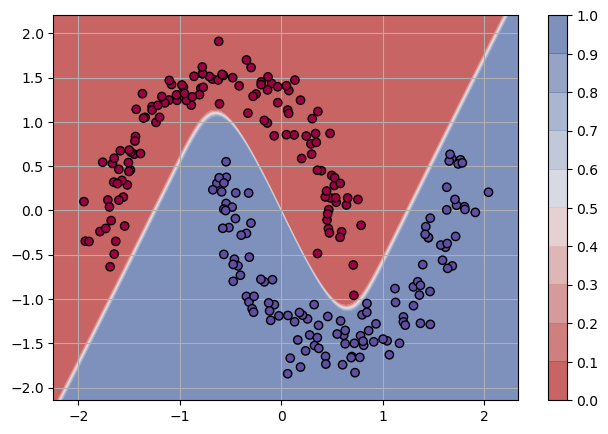

In [93]:
### CREATE A MESHGRID ###
# Create a meshgrid for the whole dataset such that we can plot the predictions for each point
h = .01  # step size in the mesh
buffer = 0.3 # buffer for the axes
x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer # min and max of the first feature
y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer # min and max of the second feature
xx,yy= np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
grid = torch.from_numpy((grid - X.mean(axis=0)) / X.std(axis=0)).float().to(DEVICE)
# mincol in red hexa code, axcol in blue hexa code
custom_map = custom_div_cmap(
    11, mincol='#B22222', midcol='0.9', maxcol='#4863A0')

### SEED ###
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

### PREDICT ###
clevels = 9
Z = network.predict(grid) 
# Depending on the loss function, we need to apply an activation function to the output
if "binary_cross_entropy" in network_data["criterion"].__name__:
    Z = Z.cpu().reshape(xx.shape)
else:    
    Z = torch.exp(Z)
    Z = torch.max(Z, dim=1)[0].reshape(xx.shape).cpu()


### PLOT ###
# Plot the predictions with the uncertainty
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
ax.grid(True)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, edgecolors='k', zorder=2)

# Plot the uncertainty with contourf based on the value of Z
c = ax.contourf(xx, yy, Z, alpha=0.7, levels=clevels, antialiased=True, cmap=custom_map, zorder=1)

# Add a colorbar
colorbar = fig.colorbar(c, ax=ax, ticks=np.arange(0, 1.1, 1 / (clevels+1)))
# force the leftbar to be between 0 and 1
c.get_clim()
c.set_clim(0, 1)
colorbar.ax.set_ylim(0, 1)

os.makedirs(SAVE_FOLDER, exist_ok=True)
plt.savefig(os.path.join(SAVE_FOLDER, "two-moons-uncertainty-STE-BiNN.pdf"), bbox_inches='tight')
plt.show()